In [ ]:
import cuml
import cudf
import numpy as np
from collections import Counter
from cuml.cluster import HDBSCAN
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/home/hice1/ltupac3/scratch/testpy/lib/python3.9/site-packages/cupy/_environment.py:541: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [ ]:
import os 
from dotenv import load_dotenv
from pathlib import Path
load_dotenv()
CSV_OUTPUT_PATH = Path(os.getenv("CSV_OUTPUT_PATH"))
CSV_FILE = os.getenv("CLEANED_ARTICLES_FILENAME")

MODEL_OUTPUT_PATH = Path(os.getenv("MODEL_OUTPUT_PATH"))
NP_OUTPUT_PATH = Path(os.getenv("NP_OUTPUT_PATH"))
MODEL_FILE = os.getenv("MODEL_FILENAME")
EMBEDDED_ARTICLES_FILENAME = os.getenv("EMBEDDED_ARTICLES_FILENAME")


CLEANED_ARTICLES_FILENAME=os.getenv("CLEANED_ARTICLES_FILENAME")
EMBEDDED_ARTICLES_FILENAME=os.getenv("EMBEDDED_ARTICLES_FILENAME")
MODEL_FILENAME=os.getenv("MODEL_FILENAME")
GROUPED_RISK_TAGS_CSV=os.getenv("GROUPED_RISK_TAGS_CSV")
ARTICLES_WITH_RISK_TAGS_CSV=os.getenv("ARTICLES_WITH_RISK_TAGS_CSV")
LM_LEXICON_FILENAME=os.getenv("LM_LEXICON_FILENAME")
STOCK_RISK_EXPOSURE_CSV=os.getenv("STOCK_RISK_EXPOSURE_CSV")
HDBSCAN_SUBCLUSTER_LABELS=os.getenv("HDBSCAN_SUBCLUSTER_LABELS")
HDBSCAN_RISK_TAGS=os.getenv("HDBSCAN_RISK_TAGS")
HDBSCAN_GROUPED_RISK_TAGS=os.getenv("HDBSCAN_GROUPED_RISK_TAGS")
EMBEDDED_FINBERT=os.getenv("EMBEDDED_FINBERT")


In [ ]:
# Load article vectors
file_path = f"{NP_OUTPUT_PATH}/{EMBEDDED_FINBERT}"
X_train = np.load(file_path)

print("Shape of embeddings:", X_train.shape)
X_cudf = cudf.DataFrame.from_records(X_train)

Shape of embeddings: (363820, 768)


In [5]:
def run_hdbscan_grid_search(X, min_cluster_sizes, min_samples_list):
    results = []

    for mcs in min_cluster_sizes:
        for ms in min_samples_list:
            if ms > mcs:
                break
            print(f"Running HDBSCAN with min_cluster_size={mcs}, min_samples={ms}")
            hdb = HDBSCAN(
                min_cluster_size=mcs,
                min_samples=ms,
                cluster_selection_method="eom",
                prediction_data=True
            )
            hdb.fit(X)

            labels = hdb.labels_.to_numpy()
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            noise_count = np.sum(labels == -1)
            label_counts = Counter(labels)
            # find max cluster size (excluding noise) -1 
            label_counts.pop(-1, None)
            biggest_cluster = max(label_counts.values()) if label_counts else 0

            results.append({
                "min_cluster_size": mcs,
                "min_samples": ms,
                "n_clusters": n_clusters,
                "noise_count": noise_count,
                "biggest_cluster": biggest_cluster,
                "label_counts": label_counts
            })

    return pd.DataFrame(results)


In [ ]:
min_cluster_sizes = range(50, 300, 50)
min_samples_list = range(25, 300, 25)
results = run_hdbscan_grid_search(X_cudf, min_cluster_sizes, min_samples_list)

Running HDBSCAN with min_cluster_size=50, min_samples=25
Running HDBSCAN with min_cluster_size=50, min_samples=50
Running HDBSCAN with min_cluster_size=100, min_samples=25
Running HDBSCAN with min_cluster_size=100, min_samples=50
Running HDBSCAN with min_cluster_size=100, min_samples=75
Running HDBSCAN with min_cluster_size=100, min_samples=100
Running HDBSCAN with min_cluster_size=150, min_samples=25
Running HDBSCAN with min_cluster_size=150, min_samples=50
Running HDBSCAN with min_cluster_size=150, min_samples=75
Running HDBSCAN with min_cluster_size=150, min_samples=100
Running HDBSCAN with min_cluster_size=150, min_samples=125
Running HDBSCAN with min_cluster_size=150, min_samples=150
Running HDBSCAN with min_cluster_size=200, min_samples=25
Running HDBSCAN with min_cluster_size=200, min_samples=50
Running HDBSCAN with min_cluster_size=200, min_samples=75
Running HDBSCAN with min_cluster_size=200, min_samples=100
Running HDBSCAN with min_cluster_size=200, min_samples=125
Running HD

In [7]:
results

,min_cluster_size,min_samples,n_clusters,noise_count,biggest_cluster,label_counts
0,50,25,330,266437,5537,"{300: 274, 93: 398, 104: 5537, 193: 150, 178: ..."
1,50,50,215,268538,7696,"{156: 827, 72: 392, 74: 5234, 139: 148, 122: 1..."
2,100,25,206,268546,5537,"{190: 274, 60: 398, 67: 5537, 130: 150, 121: 1..."
3,100,50,155,269722,7696,"{120: 827, 52: 474, 55: 5234, 105: 148, 95: 10..."
4,100,75,147,278155,5260,"{123: 827, 50: 430, 55: 5260, 106: 148, 103: 1..."
5,100,100,131,282378,5269,"{108: 827, 46: 391, 48: 5269, 93: 145, 94: 147..."
6,150,25,144,267601,7436,"{114: 827, 52: 398, 57: 5537, 103: 150, 97: 19..."
7,150,50,125,271244,7696,"{102: 827, 45: 474, 48: 5234, 83: 355, 84: 150..."
8,150,75,120,281455,5260,"{105: 827, 40: 430, 45: 5260, 86: 1490, 110: 1..."
9,150,100,105,282968,5269,"{90: 827, 40: 391, 42: 5269, 79: 1478, 99: 148..."


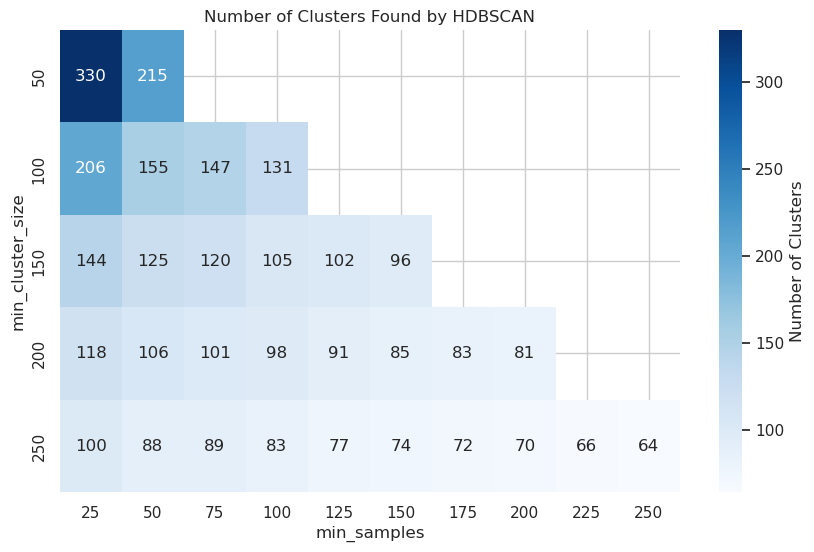

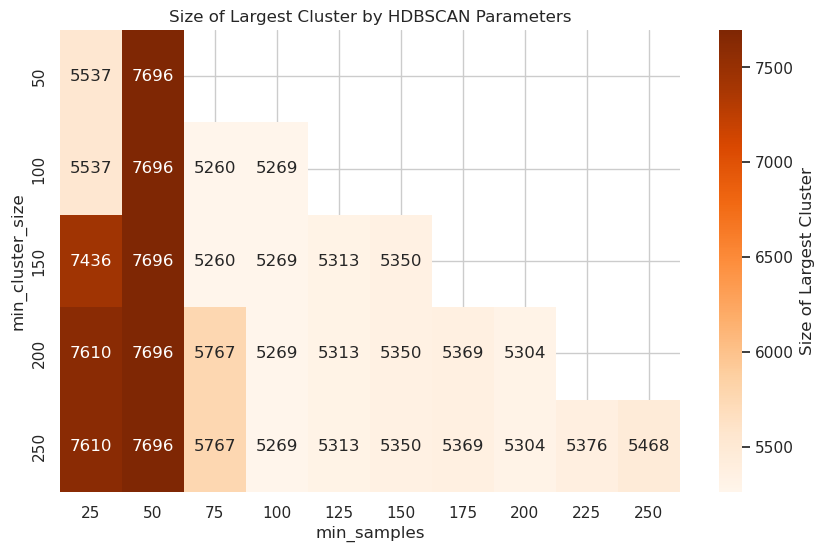

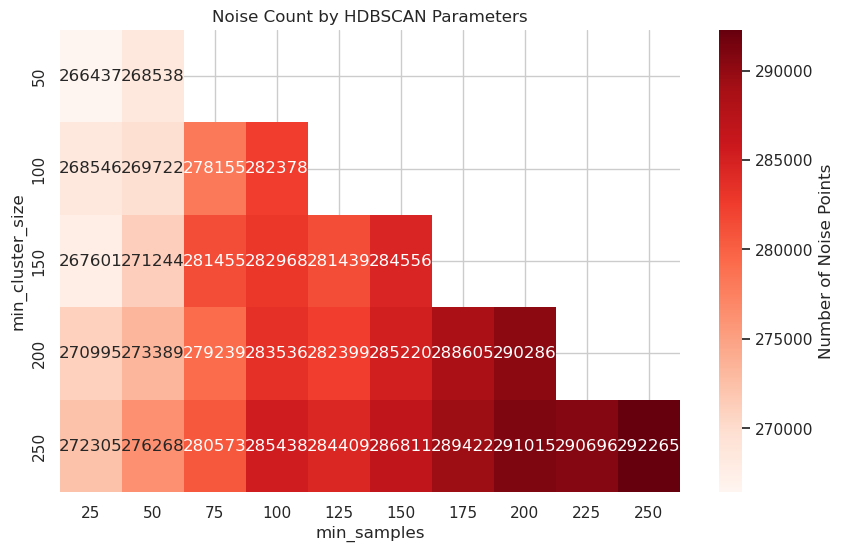

In [ ]:

# Set seaborn style
sns.set(style="whitegrid")

# Plot 1: Number of Clusters
plt.figure(figsize=(10, 6))
sns.heatmap(
    results.pivot(index="min_cluster_size", columns="min_samples", values="n_clusters"),
    annot=True, fmt=".0f", cmap="Blues", cbar_kws={'label': 'Number of Clusters'}
)
plt.title("Number of Clusters Found by HDBSCAN")
plt.xlabel("min_samples")
plt.ylabel("min_cluster_size")
plt.show()

# Plot 2: Size of Largest Cluster
plt.figure(figsize=(10, 6))
sns.heatmap(
    results.pivot(index="min_cluster_size", columns="min_samples", values="biggest_cluster"),
    annot=True, fmt=".0f", cmap="Oranges", cbar_kws={'label': 'Size of Largest Cluster'}
)
plt.title("Size of Largest Cluster by HDBSCAN Parameters")
plt.xlabel("min_samples")
plt.ylabel("min_cluster_size")
plt.show()

# Plot 3: Noise Size
plt.figure(figsize=(10, 6))
sns.heatmap(
    results.pivot(index="min_cluster_size", columns="min_samples", values="noise_count"),
    annot=True, fmt=".0f", cmap="Reds", cbar_kws={'label': 'Number of Noise Points'}
)
plt.title("Noise Count by HDBSCAN Parameters")
plt.xlabel("min_samples")
plt.ylabel("min_cluster_size")
plt.show()


seems like 50/25 have the highest number of clusters (330) with the lowest number of cluster size.

150/100 has a more conservative cluster size (102) with the smallest cluster size and moderate amount of noise...

In [ ]:
# raise Exception("Stop here")

Exception: Stop here

**51 clusters with 50/50**

In [4]:
hdb = cuml.cluster.hdbscan.HDBSCAN(
    min_cluster_size=50,
    min_samples=25,
    cluster_selection_method='eom',
    prediction_data=True
)
hdb.fit(X_cudf)

HDBSCAN()

In [ ]:

# Get labels from cuML HDBSCAN
labels = hdb.labels_.to_numpy()
cluster_counts = Counter(labels)

# Print sorted cluster sizes
for cluster_id, count in sorted(cluster_counts.items()):
    name = f"Cluster {cluster_id}" if cluster_id != -1 else "Noise (-1)"
    print(f"{name}: {count:,} articles")


Noise (-1): 266,437 articles
Cluster 0: 109 articles
Cluster 1: 1,949 articles
Cluster 2: 242 articles
Cluster 3: 105 articles
Cluster 4: 87 articles
Cluster 5: 571 articles
Cluster 6: 60 articles
Cluster 7: 99 articles
Cluster 8: 76 articles
Cluster 9: 130 articles
Cluster 10: 336 articles
Cluster 11: 347 articles
Cluster 12: 165 articles
Cluster 13: 185 articles
Cluster 14: 73 articles
Cluster 15: 63 articles
Cluster 16: 57 articles
Cluster 17: 134 articles
Cluster 18: 84 articles
Cluster 19: 135 articles
Cluster 20: 73 articles
Cluster 21: 1,712 articles
Cluster 22: 58 articles
Cluster 23: 50 articles
Cluster 24: 51 articles
Cluster 25: 125 articles
Cluster 26: 55 articles
Cluster 27: 55 articles
Cluster 28: 278 articles
Cluster 29: 52 articles
Cluster 30: 3,201 articles
Cluster 31: 68 articles
Cluster 32: 505 articles
Cluster 33: 446 articles
Cluster 34: 55 articles
Cluster 35: 104 articles
Cluster 36: 1,830 articles
Cluster 37: 57 articles
Cluster 38: 73 articles
Cluster 39: 736 a

/tmp/ipykernel_2219725/2584246978.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="viridis")


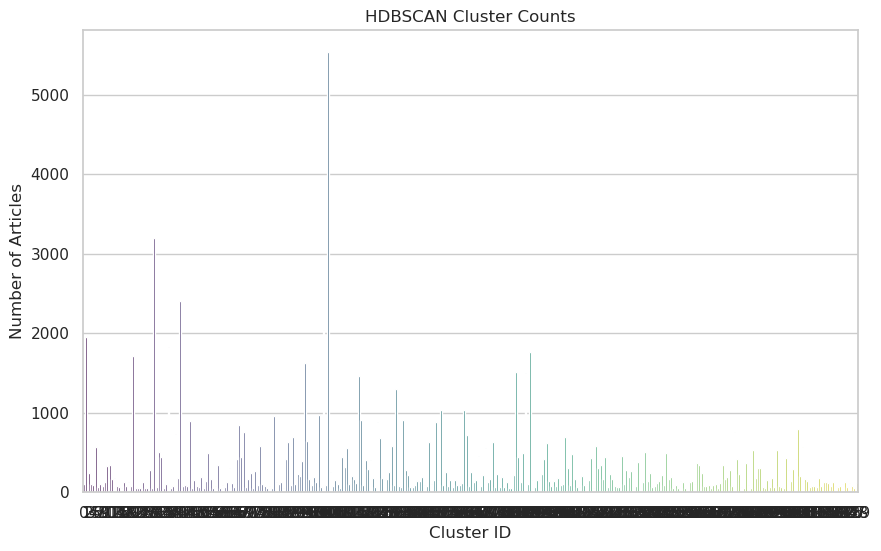

In [ ]:
# Set seaborn style
sns.set(style="whitegrid")

# remove -1 from labels 
labels = labels[labels != -1]

# Plot cluster counts
plt.figure(figsize=(10, 6))
sns.countplot(x=labels, palette="viridis")
plt.title("HDBSCAN Cluster Counts")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Articles")
plt.show()

In [ ]:
# raise Exception("Stop here after largest clusters")

Exception: Stop here after largest clusters

**81 clusters with 50/25**

In [8]:
hdb = cuml.cluster.hdbscan.HDBSCAN(
    min_cluster_size=150,
    min_samples=100,
    cluster_selection_method='eom',
    prediction_data=True
)
hdb.fit(X_cudf)

HDBSCAN()

In [ ]:
# Get labels from cuML HDBSCAN
labels = hdb.labels_.to_numpy()
cluster_counts = Counter(labels)

# Print sorted cluster sizes
for cluster_id, count in sorted(cluster_counts.items()):
    name = f"Cluster {cluster_id}" if cluster_id != -1 else "Noise (-1)"
    print(f"{name}: {count:,} articles")


Noise (-1): 282,968 articles
Cluster 0: 218 articles
Cluster 1: 256 articles
Cluster 2: 289 articles
Cluster 3: 323 articles
Cluster 4: 1,947 articles
Cluster 5: 185 articles
Cluster 6: 510 articles
Cluster 7: 220 articles
Cluster 8: 446 articles
Cluster 9: 1,830 articles
Cluster 10: 262 articles
Cluster 11: 3,199 articles
Cluster 12: 1,030 articles
Cluster 13: 164 articles
Cluster 14: 482 articles
Cluster 15: 228 articles
Cluster 16: 751 articles
Cluster 17: 419 articles
Cluster 18: 583 articles
Cluster 19: 2,079 articles
Cluster 20: 304 articles
Cluster 21: 1,710 articles
Cluster 22: 883 articles
Cluster 23: 274 articles
Cluster 24: 2,568 articles
Cluster 25: 1,433 articles
Cluster 26: 596 articles
Cluster 27: 756 articles
Cluster 28: 352 articles
Cluster 29: 873 articles
Cluster 30: 262 articles
Cluster 31: 956 articles
Cluster 32: 704 articles
Cluster 33: 213 articles
Cluster 34: 483 articles
Cluster 35: 613 articles
Cluster 36: 320 articles
Cluster 37: 569 articles
Cluster 38: 2,0

/tmp/ipykernel_2219725/2584246978.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="viridis")


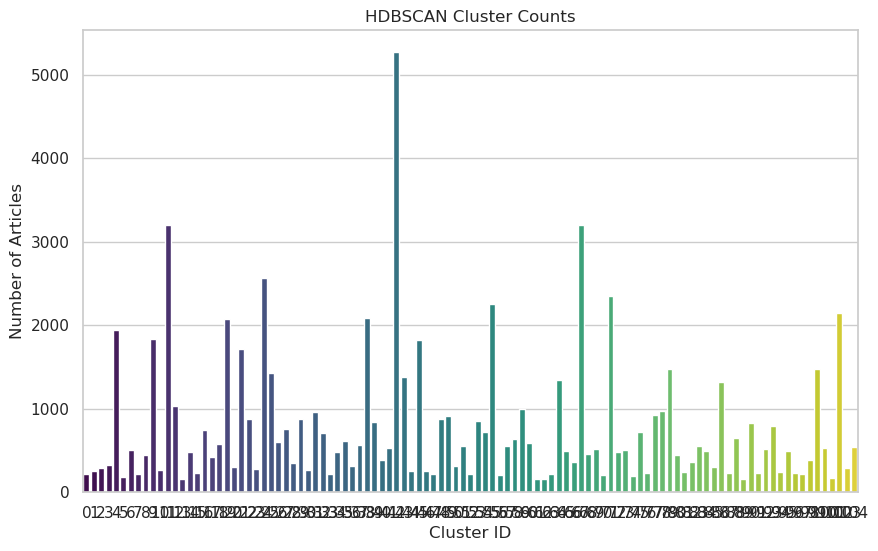

In [ ]:
# Set seaborn style
sns.set(style="whitegrid")

# remove -1 from labels 
labels = labels[labels != -1]

# Plot cluster counts
plt.figure(figsize=(10, 6))
sns.countplot(x=labels, palette="viridis")
plt.title("HDBSCAN Cluster Counts")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Articles")
plt.show()

In [ ]:
# raise Exception("Stop here")

Exception: Stop here

In [ ]:
df_cluster_counts = pd.DataFrame.from_dict(cluster_counts, orient="index", columns=["count"])
df_cluster_counts.index.name = "cluster"
df_cluster_counts = df_cluster_counts.sort_values("count", ascending=False)
# print(df_cluster_counts)


# Okay going with 150/100

In [ ]:
hdb = cuml.cluster.hdbscan.HDBSCAN(
    min_cluster_size=150,
    min_samples=100,
    cluster_selection_method='eom',
    prediction_data=True
)
hdb.fit(X_cudf)


# Get labels from cuML HDBSCAN
labels = hdb.labels_.to_numpy()
cluster_counts = Counter(labels)

In [ ]:
# np.save(f"{NP_OUTPUT_PATH}/{HDBSCAN_SUBCLUSTER_LABELS}", subcluster_labels_full)
np.save(f"{NP_OUTPUT_PATH}/{EMBEDDED_FINBERT}", labels)